# First ML Pipeline

Analysis by Jeremy Mann

Just a first pass modeling of the data using the cumulant feature engineering. The models tested were:

1. Linear SVC 
1. Random Forest
1. Gradient Boosted Classifier
1. rbfSVC

All models were chosen with their default parameters. Evaluations were just the confusion matrix plots and classfication reports built into sklearn. This was not performed through cross-validation

## Primary Insights

1. Ensemble trees performed the best, in particular the gradient boosted ones. 
1. The models' performance was not uniform along classes. 
    1. The adipose and background tissues were easily classified. 
    1. The rest of the classes were classifed with ~70 accuracy
1. Considering the "Multi-Texture.." paper, I was surprised by the relatively poor performance of the rbfSVC. 
    1. I suspect this is due to poor hyperparameter selection due to my lack of scaling? If I recall correctly, they didn't say anything preprocessing/hyperparameter selection in their paper.
    1. It's also possible that my choice of cumulants in lieu of moments was mistaken? 
  
1. My wrangle was a bit off, I'll have to go back and rewrite a lot of the code

In [100]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import kstat

from sklearn.pipeline import Pipeline 
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    plot_confusion_matrix,
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import LinearSVC, SVC

In [58]:
def load_X_train(filepath):
    X = xr.open_dataarray(filepath).values
    X = X.reshape(X.shape[0], -1)
    return X

class cumulants_extractor(BaseEstimator, TransformerMixin):
    '''
    returns a numpy array of all k-th cumulants less than 
    highest_cumulant (which must be less than 4)
    '''
    def __init__(self, highest_cumulant):
        self.highest_cumulant = highest_cumulant

    def fit(self, X, y = None):
        return self
    
    def get_cumulants(self, v):
        
        kstats = np.array([kstat(data = v, n = k) 
                          for k in range(1, self.highest_cumulant + 1)])
        return kstats
        
    def transform(self, X):
#         X = 
        cumulants = np.apply_along_axis(func1d = self.get_cumulants,
                                       axis = 1, 
                                       arr = X,
                                       )
        return cumulants

In [44]:
yfilepath = "../../data/clean_data/train_data/y_64_L_clean_train.nc"
y = xr.open_dataarray(yfilepath).values
y = np.arange(1, 9) * y
y = y.sum(axis = 1)

Xfilepath = "../../data/clean_data/train_data/X_64_L_clean_train.nc"
X = load_netcdf(Xfilepath)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

In [72]:
class_names = [
    "Tumor",
    "Stroma",
    "Complex",
    "Lympho",
    "Debris",
    "Mucosa",
    "Adipose",
    "Empty",
]

models = [
    ('Linear SVC', LinearSVC(max_iter = 10**5, dual=False)),
    ("Gradient-Boosted DTs", GradientBoostingClassifier(random_state = 42)),
    ("Random Forest", RandomForestClassifier(random_state = 42)),
    ("rbfSVC", SVC(kernel="rbf")),
]

pipelines = [
    Pipeline([("cumulant extractor", cumulants_extractor(4)), model])
    for model in models
]

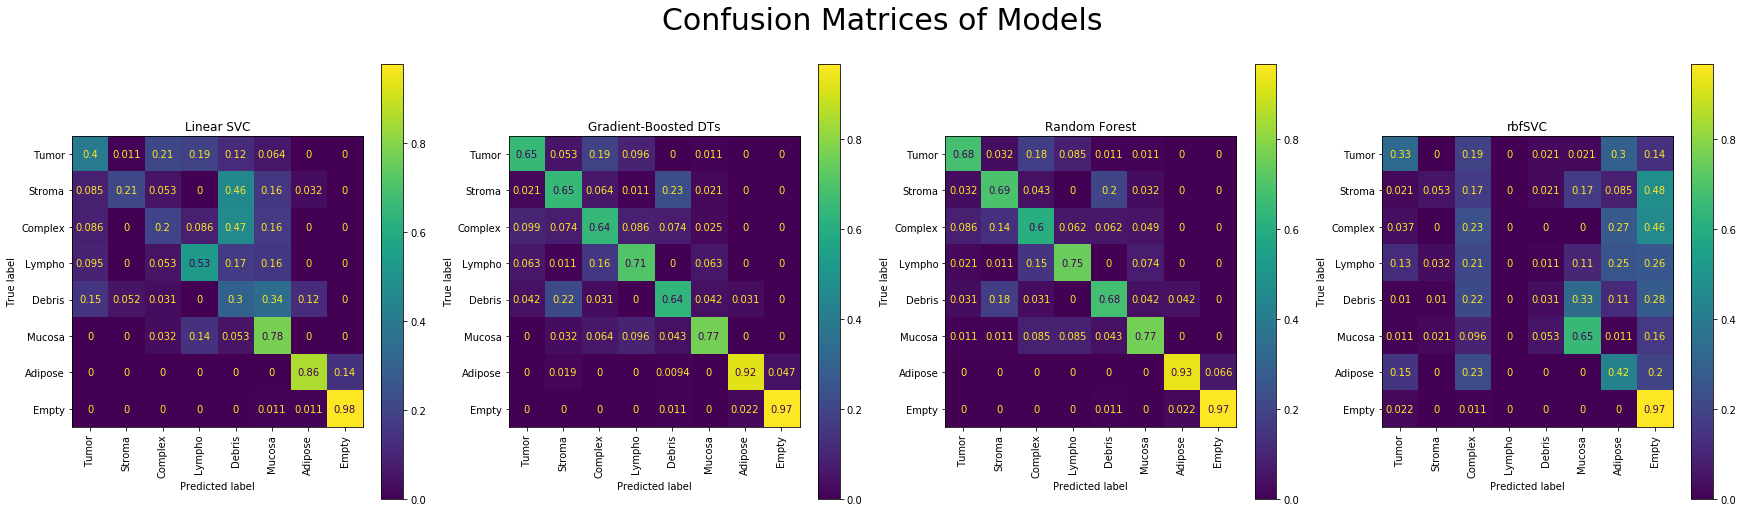

In [73]:
def plot_confusion_matrices(pipelines, X_train, y_train, X_test, y_test):
    n_of_models = len(models)
    fig, ax = plt.subplots(1, n_of_models, figsize=(30, 8))
    fig.suptitle("Confusion Matrices of Models", fontsize=30)
    for i, pipeline in enumerate(pipelines):
        pipeline.fit(X_train, y_train)
        plot_confusion_matrix(
            pipeline,
            X_test,
            y_test,
            display_labels=class_names,
            normalize="true",
            xticks_rotation="vertical",
            ax=ax[i],
        )
        ax[i].set(title=pipeline.steps[-1][0])
    plt.show()


plot_confusion_matrices(pipeplines, X_train, y_train, X_test, y_test)

In [89]:
model.steps[-1][0]

'Linear SVC'

In [103]:
for pipeline in pipelines:
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    print("Performance of " + pipeline.steps[-1][0] + "\n")
    print(
        classification_report(
            y_test,
            y_pred,
            labels=range(1, 9),
            target_names=class_names,
            zero_division=0,
        )
    )

Performance of Linear SVC

              precision    recall  f1-score   support

       Tumor       0.50      0.40      0.45        94
      Stroma       0.77      0.21      0.33        94
     Complex       0.31      0.20      0.24        81
      Lympho       0.57      0.53      0.55        95
      Debris       0.20      0.30      0.24        96
      Mucosa       0.47      0.78      0.58        94
     Adipose       0.85      0.86      0.85       106
       Empty       0.85      0.98      0.91        90

    accuracy                           0.54       750
   macro avg       0.57      0.53      0.52       750
weighted avg       0.57      0.54      0.53       750

Performance of Gradient-Boosted DTs

              precision    recall  f1-score   support

       Tumor       0.75      0.65      0.70        94
      Stroma       0.62      0.65      0.63        94
     Complex       0.52      0.64      0.57        81
      Lympho       0.72      0.71      0.71        95
      Debris  